# Place Field Analysis

This notebook demonstrates how to detect and analyze place fields using the neurospatial metrics module.

**Estimated time**: 30-35 minutes

## Learning Objectives

By the end of this notebook, you will be able to:

- Detect place fields from firing rate maps using adaptive thresholding
- Compute single-cell spatial information metrics (Skaggs information, sparsity)
- Calculate field properties including size, centroid, and peak location
- Visualize place fields overlaid on spatial environments
- Analyze spatial alternation tasks on T-maze environments
- Measure place field shift between sessions using Euclidean and geodesic distances
- Understand when to use Euclidean vs geodesic distance for shift measurement
- Use simulation tools to validate place field detection algorithms

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Import Shapely for polygon-based T-maze
from shapely.geometry import box
from shapely.ops import unary_union

# Neurospatial imports
from neurospatial import Environment
from neurospatial.encoding.place import (
    compute_place_field,
    detect_place_fields,
    field_centroid,
    field_shift_distance,
    field_size,
    field_stability,
    skaggs_information,
    sparsity,
)

# Simulation subpackage imports
from neurospatial.simulation import (
    PlaceCellModel,
    generate_poisson_spikes,
    simulate_trajectory_ou,
)

# Set random seed for reproducibility
np.random.seed(42)

## Part 1: Generate Synthetic Data

**Note**: This notebook now uses the `neurospatial.simulation` subpackage for generating synthetic data.
The simulation subpackage provides:
- Realistic trajectory generation (`simulate_trajectory_ou()`)
- Neural models (`PlaceCellModel`, `BoundaryCellModel`, `GridCellModel`)
- Spike generation (`generate_poisson_spikes()`)
- Pre-configured examples (`open_field_session()`, `tmaze_alternation_session()`)

For more details, see the simulation subpackage documentation.

We'll create a synthetic trajectory with a place cell that has:
- A single place field in the environment
- Peak firing rate of ~10 Hz
- Gaussian spatial tuning

In [2]:
# Generate 2D open field arena using simulation subpackage
arena_size = 100.0  # cm
duration = 600.0  # seconds

# Create arena environment from grid
n_grid = 50
x = np.linspace(0, arena_size, n_grid)
y = np.linspace(0, arena_size, n_grid)
xx, yy = np.meshgrid(x, y)
arena_data = np.column_stack([xx.ravel(), yy.ravel()])

env = Environment.from_samples(
    arena_data,
    bin_size=5.0,
    bin_count_threshold=1,
)
env.units = "cm"
env.frame = "open_field"

# Generate realistic trajectory using Ornstein-Uhlenbeck process
# This produces smooth, biologically realistic random exploration
positions, times = simulate_trajectory_ou(
    env,
    duration=duration,
    dt=0.02,  # 50 Hz sampling (1/0.02)
    speed_mean=7.5,  # 7.5 cm/s (realistic rat speed)
    speed_std=0.4,  # cm/s (speed variability)
    coherence_time=0.7,  # Natural exploration smoothness
    boundary_mode="reflect",  # Wrap at boundaries (avoids edge artifacts)
    seed=42,
)

print(f"Environment: {arena_size:.0f}x{arena_size:.0f} cm open field")
print(f"  {env.n_bins} bins, {env.n_dims}D")
print(f"Generated trajectory: {len(positions)} time points over {duration:.0f}s")
print(
    f"  Coverage: x=[{positions[:, 0].min():.1f}, {positions[:, 0].max():.1f}], y=[{positions[:, 1].min():.1f}, {positions[:, 1].max():.1f}] cm"
)

Environment: 100x100 cm open field
  441 bins, 2D
Generated trajectory: 30000 time points over 600s
  Coverage: x=[-2.5, 102.5], y=[-2.5, 102.5] cm


### Define Place Cell Properties

We'll create a place cell with a Gaussian place field using `PlaceCellModel`:
- Field center at (60, 50) cm
- Spatial tuning width σ = 10 cm
- Peak firing rate = 10 Hz

In [3]:
# Create place cell model using simulation subpackage
field_center = np.array([60.0, 50.0])
sigma = 10.0  # Spatial tuning width (cm)
peak_rate = 10.0  # Hz

# PlaceCellModel implements Gaussian spatial tuning
place_cell = PlaceCellModel(
    env,
    center=field_center,
    width=sigma,
    max_rate=peak_rate,
    baseline_rate=0.001,  # Minimal baseline (0.001 Hz)
    distance_metric="euclidean",  # Fast Euclidean distance
    seed=42,
)

# Compute firing rates along trajectory
firing_rate_at_position = place_cell.firing_rate(positions, times)

# Generate spike times using inhomogeneous Poisson process
spike_times = generate_poisson_spikes(
    firing_rate_at_position,
    times,
    refractory_period=0.002,  # 2ms refractory period
    seed=42,
)

print(f"Generated {len(spike_times)} spikes")
print(f"Mean firing rate: {len(spike_times) / times[-1]:.2f} Hz")
print(f"Ground truth: {place_cell.ground_truth}")

Generated 398 spikes
Mean firing rate: 0.66 Hz
Ground truth: {'center': array([60., 50.]), 'width': 10.0, 'max_rate': 10.0, 'baseline_rate': 0.001}


## Part 2: Compute Firing Rate Map

Convert spike train to a spatial firing rate map using occupancy normalization.

Firing rate range: [0.00, 7.60] Hz
Mean firing rate: 0.64 Hz


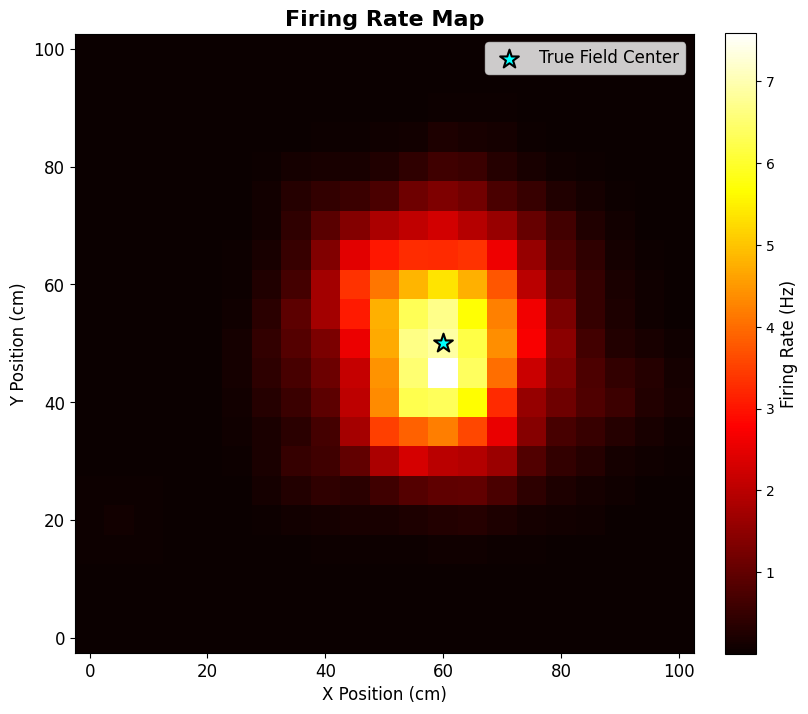

In [4]:
# Compute occupancy-normalized firing rate with smoothing
# Using diffusion KDE method (default) with 5 cm bandwidth
# This method spreads spike and occupancy mass BEFORE normalization
# and respects environment boundaries via graph connectivity
firing_rate = compute_place_field(
    env,
    spike_times,
    times,
    positions,
    smoothing_method="diffusion_kde",  # Default: boundary-aware graph-based KDE
    bandwidth=5.0,  # Spatial smoothing bandwidth (cm)
)

print(
    f"Firing rate range: [{np.nanmin(firing_rate):.2f}, {np.nanmax(firing_rate):.2f}] Hz"
)
print(f"Mean firing rate: {np.nanmean(firing_rate[~np.isnan(firing_rate)]):.2f} Hz")

# Visualize firing rate map using plot_field()
fig, ax = plt.subplots(figsize=(8, 7), constrained_layout=True)

# Plot firing rate with env.plot_field()
env.plot_field(
    firing_rate,
    ax=ax,
    cmap="hot",
    colorbar_label="Firing Rate (Hz)",
)

# Add field center marker
ax.scatter(
    field_center[0],
    field_center[1],
    s=200,
    c="cyan",
    marker="*",
    edgecolors="black",
    linewidths=1.5,
    label="True Field Center",
    zorder=10,
)

ax.set_title("Firing Rate Map", fontsize=16, fontweight="bold")
ax.legend(fontsize=12)
ax.tick_params(labelsize=12)

plt.show()

## Part 3: Detect Place Fields

Use the `detect_place_fields()` function to automatically identify place fields.

The algorithm:
1. Finds peaks in the firing rate map
2. Segments regions above 20% of peak rate
3. Uses graph connectivity to extract contiguous fields
4. Optionally detects subfields (coalescent fields)

In [5]:
# Detect place fields
place_fields = detect_place_fields(
    firing_rate,
    env,
    threshold=0.2,  # Segment at 20% of peak rate
    min_size=None,  # No minimum size (auto: 9 bins)
    max_mean_rate=10.0,  # Exclude interneurons (>10 Hz mean rate)
    detect_subfields=True,  # Detect coalescent subfields
)

print(f"Detected {len(place_fields)} place field(s)")

for i, field_bins in enumerate(place_fields):
    print(f"\nField {i + 1}:")
    print(f"  Number of bins: {len(field_bins)}")
    print(f"  Peak rate: {np.max(firing_rate[field_bins]):.2f} Hz")
    print(f"  Mean rate in field: {np.mean(firing_rate[field_bins]):.2f} Hz")

Detected 1 place field(s)

Field 1:
  Number of bins: 60
  Peak rate: 7.60 Hz
  Mean rate in field: 3.67 Hz


### Visualize Detected Place Fields

Show the detected place fields overlaid on the firing rate map.

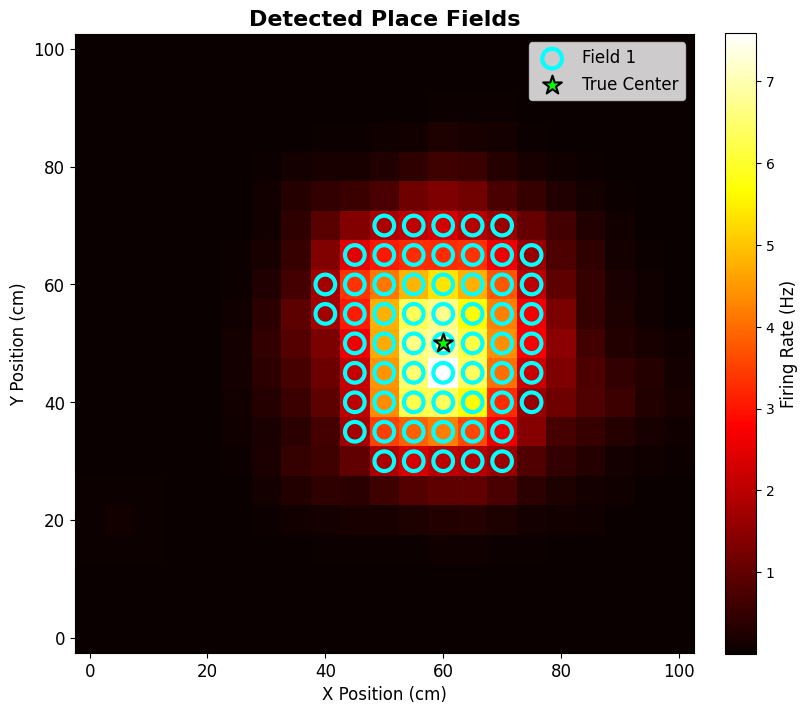

In [6]:
fig, ax = plt.subplots(figsize=(8, 7), constrained_layout=True)

# Plot firing rate (background) using plot_field()
env.plot_field(
    firing_rate,
    ax=ax,
    cmap="hot",
    colorbar_label="Firing Rate (Hz)",
)

# Plot detected place field bins
if len(place_fields) > 0:
    for i, field_bins in enumerate(place_fields):
        ax.scatter(
            env.bin_centers[field_bins, 0],
            env.bin_centers[field_bins, 1],
            s=200,
            facecolors="none",
            edgecolors="cyan",
            linewidths=3,
            label=f"Field {i + 1}" if i == 0 else "",
        )

# Add true field center
ax.scatter(
    field_center[0],
    field_center[1],
    s=200,
    c="lime",
    marker="*",
    edgecolors="black",
    linewidths=1.5,
    label="True Center",
    zorder=10,
)

ax.set_title("Detected Place Fields", fontsize=16, fontweight="bold")
ax.legend(fontsize=12)
ax.tick_params(labelsize=12)

plt.show()

## Part 4: Compute Field Properties

For each detected field, compute:
- Field size (area in cm²)
- Field centroid (center of mass, weighted by firing rate)

In [7]:
# Compute field properties
for i, field_bins in enumerate(place_fields):
    # Field size (area in physical units)
    area = field_size(field_bins, env)

    # Field centroid (center of mass)
    centroid = field_centroid(firing_rate, field_bins, env)

    # Distance from true center
    distance_from_true = np.linalg.norm(centroid - field_center)

    print(f"\nField {i + 1} Properties:")
    print(f"  Area: {area:.1f} cm²")
    print(f"  Centroid: ({centroid[0]:.1f}, {centroid[1]:.1f}) cm")
    print(f"  Distance from true center: {distance_from_true:.1f} cm")


Field 1 Properties:
  Area: 1500.0 cm²
  Centroid: (59.1, 50.1) cm
  Distance from true center: 0.9 cm


## Part 5: Compute Single-Cell Spatial Metrics

Compute standard neuroscience metrics that quantify spatial coding quality:

**Skaggs Spatial Information** (Skaggs et al., 1993)
- Measures how much information (in bits) the firing rate conveys about position
- Typical range: 0-3+ bits/spike
- Higher values = better place cell

**Sparsity** (Skaggs et al., 1996)
- Measures how focally a cell fires in space
- Range: [0, 1], where 0 = fires everywhere, 1 = fires in single location
- Typical place cells: 0.1-0.5

In [8]:
# Compute occupancy for metrics
occupancy = env.occupancy(times, positions, return_seconds=True)

# Skaggs spatial information (bits/spike)
spatial_info = skaggs_information(firing_rate, occupancy, base=2.0)

# Sparsity
sparsity_score = sparsity(firing_rate, occupancy)

print("\nSpatial Coding Metrics:")
print(f"  Skaggs Information: {spatial_info:.3f} bits/spike")
print(f"  Sparsity: {sparsity_score:.3f}")
print("\nInterpretation:")
print(
    f"  - Spatial information > 1.0: Strong spatial coding (this cell: {'YES' if spatial_info > 1.0 else 'NO'})"
)
print(
    f"  - Sparsity > 0.2: Focal firing (this cell: {'YES' if sparsity_score > 0.2 else 'NO'})"
)


Spatial Coding Metrics:
  Skaggs Information: 2.084 bits/spike
  Sparsity: 0.171

Interpretation:
  - Spatial information > 1.0: Strong spatial coding (this cell: YES)
  - Sparsity > 0.2: Focal firing (this cell: NO)


## Part 6: Field Stability

Assess whether the place field is stable across time by splitting the session in half
and computing the correlation between firing rate maps.

High correlation (> 0.7) indicates a stable place field.


Field Stability:
  Pearson correlation: 0.751
  Spearman correlation: 0.533

Interpretation:
  - Correlation > 0.7: Stable field (this cell: YES)


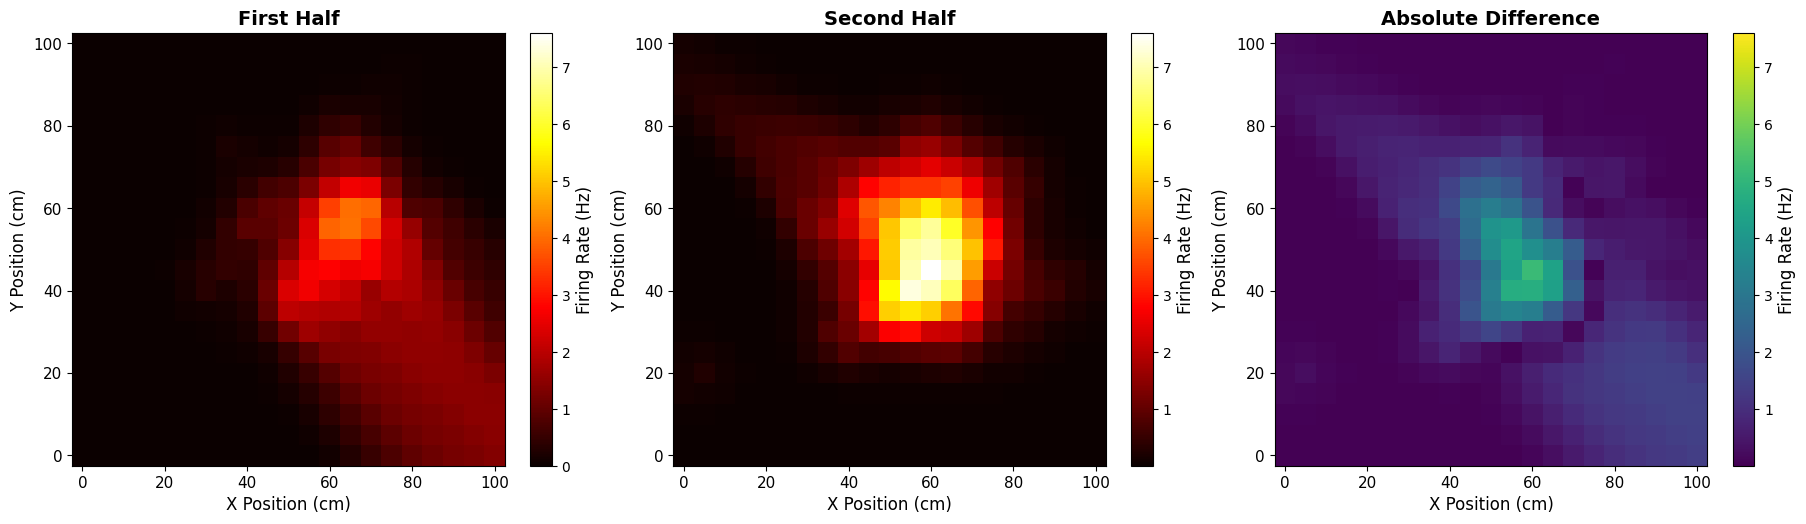

In [9]:
# Split session in half
mid_time = times[len(times) // 2]
first_half_mask = times < mid_time
second_half_mask = times >= mid_time

# Compute firing rates for each half
firing_rate_half1 = compute_place_field(
    env,
    spike_times[spike_times < mid_time],
    times[first_half_mask],
    positions[first_half_mask],
    bandwidth=5.0,
)

firing_rate_half2 = compute_place_field(
    env,
    spike_times[spike_times >= mid_time],
    times[second_half_mask],
    positions[second_half_mask],
    bandwidth=5.0,
)

# Compute stability (correlation between halves)
stability_pearson = field_stability(
    firing_rate_half1, firing_rate_half2, method="pearson"
)
stability_spearman = field_stability(
    firing_rate_half1, firing_rate_half2, method="spearman"
)

print("\nField Stability:")
print(f"  Pearson correlation: {stability_pearson:.3f}")
print(f"  Spearman correlation: {stability_spearman:.3f}")
print("\nInterpretation:")
print(
    f"  - Correlation > 0.7: Stable field (this cell: {'YES' if stability_pearson > 0.7 else 'NO'})"
)

# Visualize both halves
fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

for ax, rate_map, title in zip(
    axes,
    [
        firing_rate_half1,
        firing_rate_half2,
        np.abs(firing_rate_half1 - firing_rate_half2),
    ],
    ["First Half", "Second Half", "Absolute Difference"],
    strict=True,
):
    env.plot_field(
        rate_map,
        ax=ax,
        cmap="hot" if "Difference" not in title else "viridis",
        vmax=np.nanmax(firing_rate),
        colorbar_label="Firing Rate (Hz)",
    )

    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.tick_params(labelsize=11)

plt.show()

## Part 7: Complete Workflow Summary

Here's a complete example of the typical place field analysis workflow:

In [10]:
def analyze_place_cell(env, spike_times, times, positions):
    """
    Complete place field analysis workflow.

    Parameters
    ----------
    env : Environment
        Spatial environment
    spike_times : ndarray
        Spike times (seconds)
    times : ndarray
        Trajectory time points (seconds)
    positions : ndarray
        Trajectory positions (N × D)

    Returns
    -------
    results : dict
        Dictionary containing all metrics and detected fields
    """
    # Step 1: Compute firing rate map
    firing_rate = compute_place_field(
        env,
        spike_times,
        times,
        positions,
        bandwidth=5.0,
    )

    # Step 2: Detect place fields
    place_fields = detect_place_fields(
        firing_rate,
        env,
        threshold=0.2,
        max_mean_rate=10.0,
        detect_subfields=True,
    )

    # Step 3: Compute field properties
    field_properties = []
    for field_bins in place_fields:
        field_properties.append(
            {
                "area": field_size(field_bins, env),
                "centroid": field_centroid(firing_rate, field_bins, env),
                "peak_rate": np.max(firing_rate[field_bins]),
                "mean_rate": np.mean(firing_rate[field_bins]),
            }
        )

    # Step 4: Compute spatial metrics
    occupancy = env.occupancy(times, positions, return_seconds=True)
    spatial_info = skaggs_information(firing_rate, occupancy, base=2.0)
    sparsity_score = sparsity(firing_rate, occupancy)

    # Step 5: Assess stability (split-half)
    mid_time = times[len(times) // 2]
    first_half = times < mid_time
    second_half = times >= mid_time

    rate_half1 = compute_place_field(
        env,
        spike_times[spike_times < mid_time],
        times[first_half],
        positions[first_half],
        bandwidth=5.0,
    )

    rate_half2 = compute_place_field(
        env,
        spike_times[spike_times >= mid_time],
        times[second_half],
        positions[second_half],
        bandwidth=5.0,
    )

    stability = field_stability(rate_half1, rate_half2, method="pearson")

    return {
        "firing_rate": firing_rate,
        "place_fields": place_fields,
        "field_properties": field_properties,
        "spatial_information": spatial_info,
        "sparsity": sparsity_score,
        "stability": stability,
        "n_fields": len(place_fields),
    }


# Run complete analysis
results = analyze_place_cell(env, spike_times, times, positions)

print("\n" + "=" * 60)
print("COMPLETE PLACE CELL ANALYSIS SUMMARY")
print("=" * 60)
print(f"\nPlace Fields: {results['n_fields']} detected")
print(f"Spatial Information: {results['spatial_information']:.3f} bits/spike")
print(f"Sparsity: {results['sparsity']:.3f}")
print(f"Stability: {results['stability']:.3f}")
print(
    f"\nClassification: {'PLACE CELL' if results['spatial_information'] > 1.0 and results['n_fields'] > 0 else 'NOT A PLACE CELL'}"
)


COMPLETE PLACE CELL ANALYSIS SUMMARY

Place Fields: 1 detected
Spatial Information: 2.084 bits/spike
Sparsity: 0.171
Stability: 0.751

Classification: PLACE CELL


---

## Part 8: Place Remapping in Different Environments

**Place remapping** occurs when place cells change their firing patterns between different environments or contexts. This demonstrates how neurospatial handles irregular environments like T-mazes and how to quantify remapping.

### Types of Remapping:

- **Global remapping**: Complete reorganization of place fields (different contexts)
- **Rate remapping**: Same locations, different rates (similar contexts)
- **Partial remapping**: Some cells remap, others maintain fields

We'll compare place fields between the open field and a T-maze to demonstrate remapping analysis.

### Create 2D T-Maze with Shapely Polygon

T-mazes are commonly used to study spatial memory and decision-making. They have:
- A start box
- A stem leading to a choice point
- Left and right arms

We'll create a 2D T-maze using Shapely polygons and `Environment.from_polygon()`.

In [11]:
# Create T-maze shape using Shapely polygons
# Simple T-maze with uniform corridor width throughout
corridor_width = 15.0  # Width of all corridors
stem_length = 60.0  # Length of vertical stem
arm_length = 50.0  # Length of each horizontal arm from center

# Small overlap to ensure boxes merge into a single polygon
overlap = 0.1

# Create T-maze as two intersecting rectangles
# Vertical stem (from bottom to junction)
stem = box(
    -corridor_width / 2,
    0,  # Start at y=0 (bottom)
    corridor_width / 2,
    stem_length + overlap,  # Extend slightly into horizontal bar
)

# Horizontal bar at top (single continuous rectangle)
horizontal_bar = box(
    -arm_length,  # Left edge
    stem_length - overlap,  # Slightly below stem top for overlap
    arm_length,  # Right edge
    stem_length + corridor_width,  # Top edge
)

# Combine stem and horizontal bar into single T-maze polygon
tmaze_polygon = unary_union([stem, horizontal_bar])

# Create environment from polygon
tmaze_env = Environment.from_polygon(
    polygon=tmaze_polygon,
    bin_size=5.0,
)
tmaze_env.units = "cm"
tmaze_env.frame = "tmaze"

# Generate trajectory on T-maze
tmaze_positions, tmaze_times = simulate_trajectory_ou(
    tmaze_env,
    duration=400.0,  # Longer duration for good coverage of all arms
    dt=0.02,
    speed_mean=12.0,  # cm/s
    speed_std=3.0,
    coherence_time=0.8,  # Longer coherence for smoother paths
    boundary_mode="reflect",
    seed=42,
)

print(f"\nT-Maze Environment: {tmaze_env.n_bins} bins")
print(f"  Generated {len(tmaze_positions)} trajectory points")
print(
    f"  Coverage: x=[{tmaze_positions[:, 0].min():.1f}, {tmaze_positions[:, 0].max():.1f}], "
    f"y=[{tmaze_positions[:, 1].min():.1f}, {tmaze_positions[:, 1].max():.1f}] cm"
)
print(f"  Maze extent: {tmaze_polygon.bounds}")

# Create a single place cell for the T-maze
# Position field at choice point (junction of stem and horizontal arms)
tmaze_field_center = np.array([0.0, stem_length])

pc_tmaze = PlaceCellModel(
    tmaze_env,
    center=tmaze_field_center,
    width=12.0,
    max_rate=15.0,
    baseline_rate=0.1,
    distance_metric="euclidean",
    seed=42,
)

tmaze_spike_times = generate_poisson_spikes(
    firing_rate=pc_tmaze.firing_rate(tmaze_positions, tmaze_times),
    times=tmaze_times,
    refractory_period=0.002,
    seed=42,
)

print(f"\nGenerated {len(tmaze_spike_times)} spikes for T-maze place cell")
print(f"Place field center: {tmaze_field_center}")


T-Maze Environment: 84 bins
  Generated 20000 trajectory points
  Coverage: x=[-50.0, 50.0], y=[0.0, 75.0] cm
  Maze extent: (-50.0, 0.0, 50.0, 75.0)

Generated 1529 spikes for T-maze place cell
Place field center: [ 0. 60.]


### Visualize T-Maze Environment

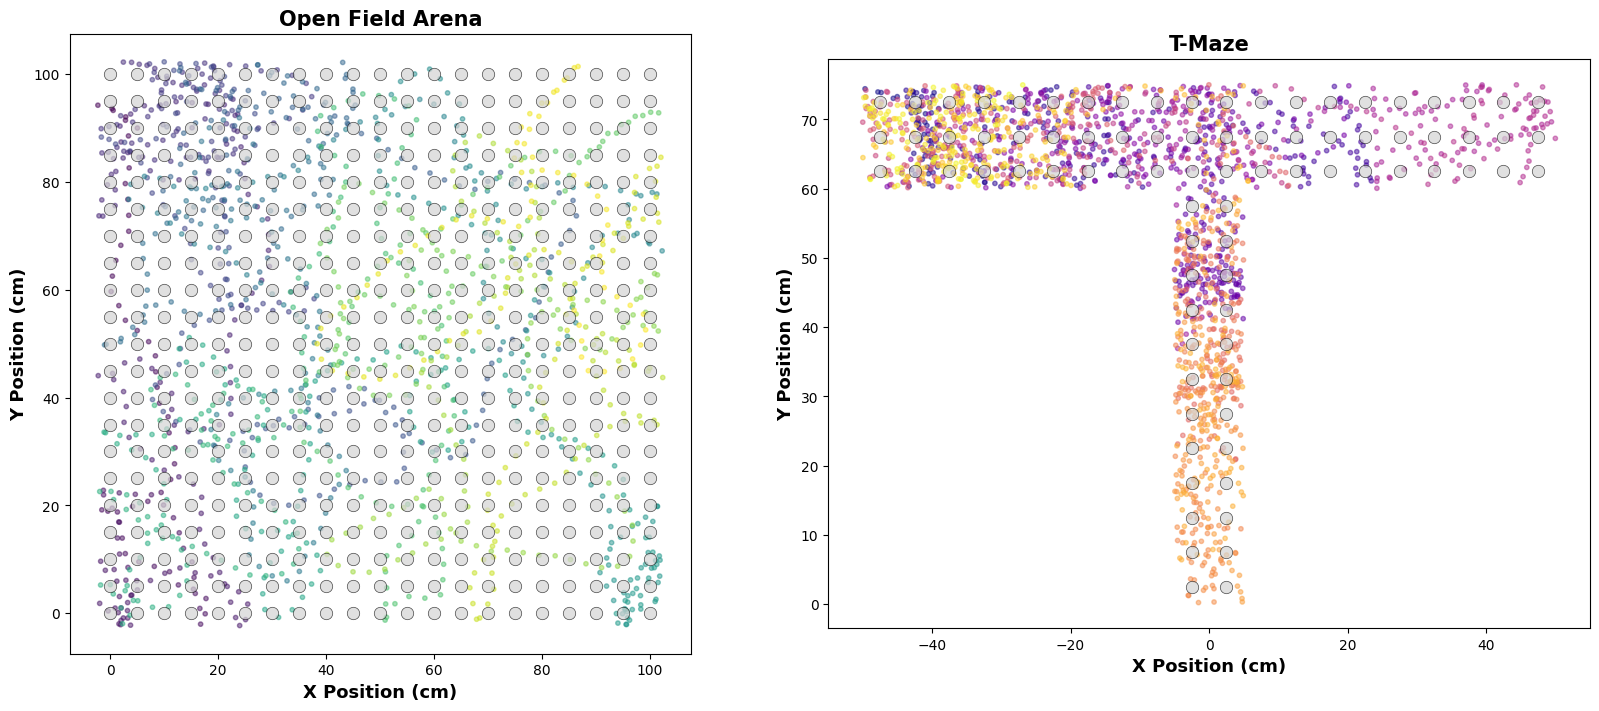

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7), constrained_layout=True)

# Open field trajectory
axes[0].scatter(
    positions[::20, 0],
    positions[::20, 1],
    c=np.arange(len(positions[::20])),
    cmap="viridis",
    s=10,
    alpha=0.5,
)
axes[0].scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c="lightgray",
    s=80,
    edgecolors="black",
    linewidths=0.5,
    alpha=0.7,
)
axes[0].set_xlabel("X Position (cm)", fontsize=13, fontweight="bold")
axes[0].set_ylabel("Y Position (cm)", fontsize=13, fontweight="bold")
axes[0].set_title("Open Field Arena", fontsize=15, fontweight="bold")
axes[0].set_aspect("equal")

# T-maze trajectory
axes[1].scatter(
    tmaze_positions[::10, 0],
    tmaze_positions[::10, 1],
    c=np.arange(len(tmaze_positions[::10])),
    cmap="plasma",
    s=10,
    alpha=0.5,
)
axes[1].scatter(
    tmaze_env.bin_centers[:, 0],
    tmaze_env.bin_centers[:, 1],
    c="lightgray",
    s=80,
    edgecolors="black",
    linewidths=0.5,
    alpha=0.7,
)
axes[1].set_xlabel("X Position (cm)", fontsize=13, fontweight="bold")
axes[1].set_ylabel("Y Position (cm)", fontsize=13, fontweight="bold")
axes[1].set_title("T-Maze", fontsize=15, fontweight="bold")
axes[1].set_aspect("equal")

plt.show()

### Compute Place Field for T-Maze

Now compute the firing rate map for the T-maze place cell.

In [13]:
# Compute firing rate map for T-maze
tmaze_firing_rate = compute_place_field(
    tmaze_env,
    tmaze_spike_times,
    tmaze_times,
    tmaze_positions,
    bandwidth=8.0,  # Consistent smoothing
)

print("\nComputed T-maze firing rate map:")
print(f"  Peak rate: {tmaze_firing_rate.max():.2f} Hz")
print(f"  Mean rate: {tmaze_firing_rate.mean():.2f} Hz")


Computed T-maze firing rate map:
  Peak rate: 10.06 Hz
  Mean rate: 3.88 Hz


### Visualize Remapping: Same Cell, Two Environments

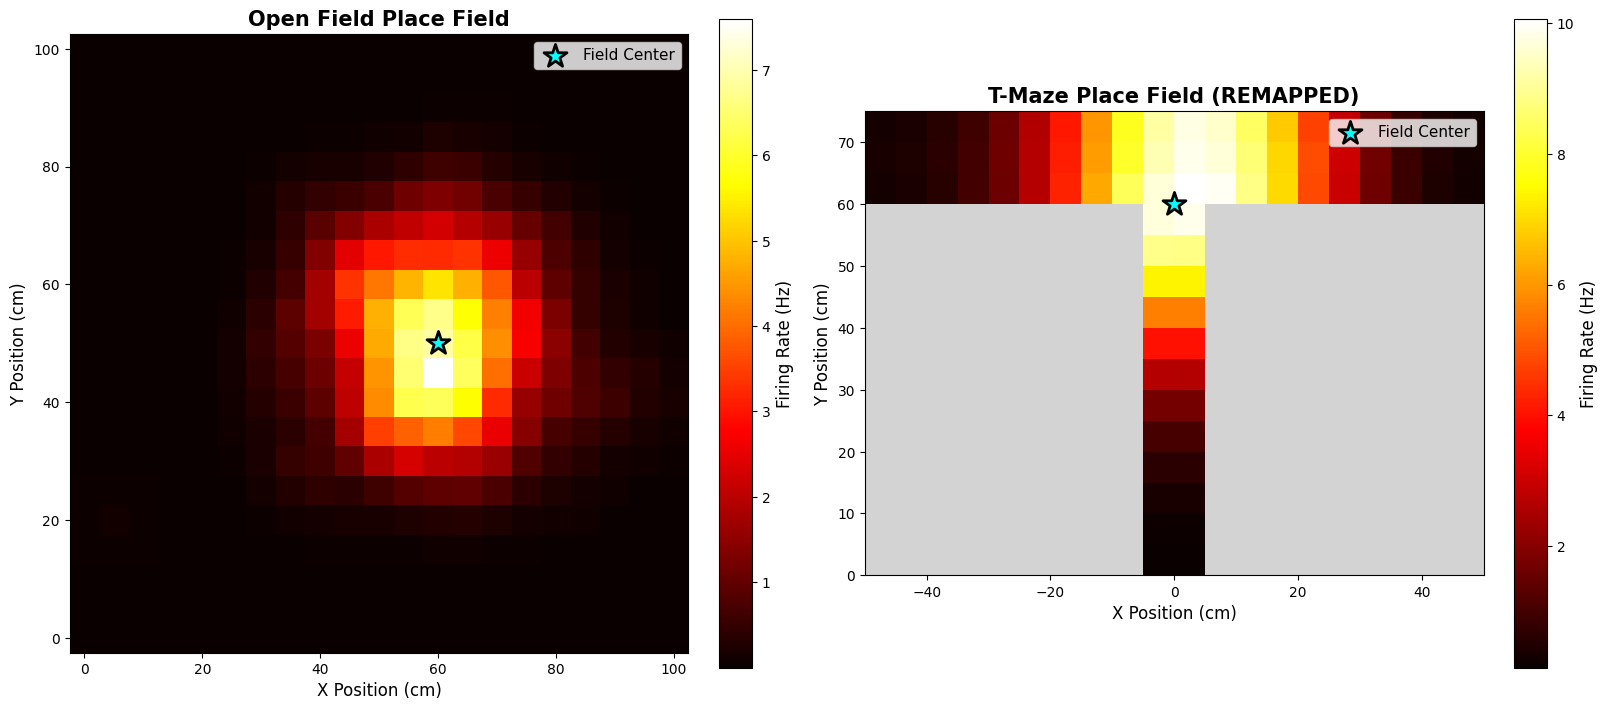


REMAPPING DETECTED
Open field center: [60. 50.]
T-maze center:     [ 0. 60.]
Distance moved:    60.8 cm

This demonstrates GLOBAL REMAPPING - the place field
completely reorganized in the new environment!


In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7), constrained_layout=True)

# Open field place field
env.plot_field(
    firing_rate,
    ax=axes[0],
    cmap="hot",
    colorbar_label="Firing Rate (Hz)",
)
axes[0].scatter(
    field_center[0],
    field_center[1],
    s=300,
    c="cyan",
    marker="*",
    edgecolors="black",
    linewidths=2,
    label="Field Center",
    zorder=10,
)
axes[0].set_title("Open Field Place Field", fontsize=15, fontweight="bold")
axes[0].legend(fontsize=11)

# T-maze place field
tmaze_env.plot_field(
    tmaze_firing_rate,
    ax=axes[1],
    cmap="hot",
    colorbar_label="Firing Rate (Hz)",
)
axes[1].scatter(
    tmaze_field_center[0],
    tmaze_field_center[1],
    s=300,
    c="cyan",
    marker="*",
    edgecolors="black",
    linewidths=2,
    label="Field Center",
    zorder=10,
)
axes[1].set_title("T-Maze Place Field (REMAPPED)", fontsize=15, fontweight="bold")
axes[1].legend(fontsize=11)

plt.show()

print("\n" + "=" * 60)
print("REMAPPING DETECTED")
print("=" * 60)
print(f"Open field center: {field_center}")
print(f"T-maze center:     {tmaze_field_center}")
print(f"Distance moved:    {np.linalg.norm(field_center - tmaze_field_center):.1f} cm")
print("\nThis demonstrates GLOBAL REMAPPING - the place field")
print("completely reorganized in the new environment!")

### Quantify Remapping with Spatial Correlation

We can't directly compare firing rates between different environments (different bin positions). Instead, we use **spatial correlation** by interpolating one map onto the other's coordinates.

For environments with overlapping spatial extent, we can:
1. Find bins that exist in both environments
2. Interpolate firing rates to common positions
3. Compute correlation

**Note**: For very different geometries (like open field vs T-maze), spatial correlation is less meaningful. Population vector correlation (across multiple cells) is more appropriate.

In [15]:
def compute_spatial_correlation_overlap(env1, rate1, env2, rate2):
    """
    Compute spatial correlation for overlapping region of two environments.

    This is a simplified approach - finds bins in env2 closest to env1 bins
    within a distance threshold.
    """
    from scipy.spatial.distance import cdist

    # Find overlapping bins (bins in env1 close to bins in env2)
    distances = cdist(env1.bin_centers, env2.bin_centers)

    # For each bin in env1, find closest bin in env2
    closest_env2_bins = np.argmin(distances, axis=1)
    min_distances = np.min(distances, axis=1)

    # Only use bins within 5 cm (approximately overlapping)
    overlap_threshold = 5.0  # cm
    overlap_mask = min_distances < overlap_threshold

    if overlap_mask.sum() < 5:
        return np.nan, 0

    # Get firing rates for overlapping bins
    rate1_overlap = rate1[overlap_mask]
    rate2_overlap = rate2[closest_env2_bins[overlap_mask]]

    # Remove NaN values
    valid = ~np.isnan(rate1_overlap) & ~np.isnan(rate2_overlap)

    if valid.sum() < 5:
        return np.nan, valid.sum()

    # Compute correlation
    corr = np.corrcoef(rate1_overlap[valid], rate2_overlap[valid])[0, 1]

    return corr, valid.sum()


# Compute spatial correlation
spatial_corr, n_overlap = compute_spatial_correlation_overlap(
    env, firing_rate, tmaze_env, tmaze_firing_rate
)

print("\nSpatial Correlation (Remapping Metric):")
print(f"  Correlation: {spatial_corr:.3f}")
print(f"  Overlapping bins: {n_overlap}")
print("\nInterpretation:")
print("  > 0.7: Same place field (stable)")
print("  0.3-0.7: Partial remapping")
print("  < 0.3: Complete remapping (this cell)")


Spatial Correlation (Remapping Metric):
  Correlation: -0.430
  Overlapping bins: 68

Interpretation:
  > 0.7: Same place field (stable)
  0.3-0.7: Partial remapping
  < 0.3: Complete remapping (this cell)


---

## Part 9: Measuring Place Field Shift

When analyzing place fields across sessions or conditions, we often want to quantify **how much a place field has shifted in position**. The `field_shift_distance()` function computes the distance between field centroids and supports both:

- **Euclidean distance**: Straight-line distance (fast, appropriate for open fields)
- **Geodesic distance**: Shortest path through environment connectivity (respects walls and barriers)

We'll demonstrate both approaches with clear examples where the shift is obvious and measurable.

### Example 1: Linear Track with Known Shift (Euclidean Distance)

First, let's create a simple 2D rectangular environment and simulate two sessions where the same place cell's field shifts by a known amount. This demonstrates Euclidean distance measurement where the answer is obvious.

In [16]:
# Create a simple 2D rectangular environment (like a linear track)
# Match 08_spike_field_basics.py approach: create REGULAR GRID first, then generate trajectory
# This avoids masked grids which cause grey squares in visualization

# Define track boundaries
track_length = 100.0  # cm
track_width = 30.0  # cm (narrow corridor)
bin_size = 5.0  # cm

# Create proper regular grid covering the track (like 08_spike_field_basics.py does)
x = np.linspace(0, track_length, int(track_length / bin_size) + 1)
y = np.linspace(40, 40 + track_width, int(track_width / bin_size) + 1)
xx, yy = np.meshgrid(x, y)
track_grid_data = np.column_stack([xx.ravel(), yy.ravel()])

# Create environment from regular grid (NOT from trajectory)
track_env = Environment.from_samples(
    track_grid_data,
    bin_size=bin_size,
)
track_env.units = "cm"
track_env.frame = "linear_track"

# Generate trajectory on this environment
track_positions, track_times = simulate_trajectory_ou(
    track_env,
    duration=600.0,  # Long duration for complete coverage
    dt=0.02,
    speed_mean=10.0,
    speed_std=3.0,
    coherence_time=0.5,  # More exploration
    boundary_mode="reflect",
    seed=100,
)

print(f"Linear track environment: {track_env.n_bins} bins")
print(
    f"  Extent: x=[{track_env.dimension_ranges[0][0]:.1f}, {track_env.dimension_ranges[0][1]:.1f}] cm"
)
print(
    f"  Width: y=[{track_env.dimension_ranges[1][0]:.1f}, {track_env.dimension_ranges[1][1]:.1f}] cm"
)

# DIAGNOSTIC: Check if environment has active_mask (which causes grey squares)
if (
    hasattr(track_env.layout, "active_mask")
    and track_env.layout.active_mask is not None
):
    print("  ⚠️  Environment has MASKED GRID")
    print(f"  Grid shape: {track_env.layout.grid_shape}")
    print(f"  Active bins: {track_env.n_bins}")
    print(f"  Total grid cells: {np.prod(track_env.layout.grid_shape)}")
    print(
        f"  Inactive (grey) bins: {np.prod(track_env.layout.grid_shape) - track_env.n_bins}"
    )
else:
    print("  ✓ Regular grid (no masking)")

# Session 1: Place field at x=30 cm
field_center_session1 = np.array([30.0, 50.0])
pc_session1 = PlaceCellModel(
    track_env,
    center=field_center_session1,
    width=8.0,
    max_rate=15.0,
    baseline_rate=0.1,
    distance_metric="euclidean",
    seed=100,
)

spikes_session1 = generate_poisson_spikes(
    firing_rate=pc_session1.firing_rate(track_positions, track_times),
    times=track_times,
    refractory_period=0.002,
    seed=100,
)

rate_session1 = compute_place_field(
    track_env,
    spikes_session1,
    track_times,
    track_positions,
    bandwidth=8.0,  # Match 08_spike_field_basics.py for consistent smoothing
)

# Session 2: Same cell, but field shifted 20 cm to the right (x=50 cm)
field_center_session2 = np.array([50.0, 50.0])  # 20 cm shift
pc_session2 = PlaceCellModel(
    track_env,
    center=field_center_session2,
    width=8.0,
    max_rate=15.0,
    baseline_rate=0.1,
    distance_metric="euclidean",
    seed=100,
)

spikes_session2 = generate_poisson_spikes(
    firing_rate=pc_session2.firing_rate(track_positions, track_times),
    times=track_times,
    refractory_period=0.002,
    seed=101,
)

rate_session2 = compute_place_field(
    track_env,
    spikes_session2,
    track_times,
    track_positions,
    bandwidth=8.0,  # Match 08_spike_field_basics.py for consistent smoothing
)

print(f"\nSession 1: {len(spikes_session1)} spikes, field at {field_center_session1}")
print(f"Session 2: {len(spikes_session2)} spikes, field at {field_center_session2}")
print(
    f"Ground truth shift: {np.linalg.norm(field_center_session2 - field_center_session1):.1f} cm"
)

Linear track environment: 147 bins
  Extent: x=[-2.5, 102.5] cm
  Width: y=[37.5, 72.5] cm
  ⚠️  Environment has MASKED GRID
  Grid shape: (21, 7)
  Active bins: 147
  Total grid cells: 147
  Inactive (grey) bins: 0

Session 1: 1063 spikes, field at [30. 50.]
Session 2: 1205 spikes, field at [50. 50.]
Ground truth shift: 20.0 cm


In [17]:
# Detect fields in both sessions
fields_session1 = detect_place_fields(
    rate_session1,
    track_env,
    threshold=0.2,
    detect_subfields=False,
)

fields_session2 = detect_place_fields(
    rate_session2,
    track_env,
    threshold=0.2,
    detect_subfields=False,
)

print("\nDetected fields:")
print(f"  Session 1: {len(fields_session1)} field(s)")
print(f"  Session 2: {len(fields_session2)} field(s)")

# Compute centroids
if len(fields_session1) > 0 and len(fields_session2) > 0:
    centroid_s1 = field_centroid(rate_session1, fields_session1[0], track_env)
    centroid_s2 = field_centroid(rate_session2, fields_session2[0], track_env)

    print("\nDetected centroids:")
    print(f"  Session 1: ({centroid_s1[0]:.1f}, {centroid_s1[1]:.1f}) cm")
    print(f"  Session 2: ({centroid_s2[0]:.1f}, {centroid_s2[1]:.1f}) cm")


Detected fields:
  Session 1: 1 field(s)
  Session 2: 1 field(s)

Detected centroids:
  Session 1: (31.1, 52.4) cm
  Session 2: (50.8, 52.8) cm


In [18]:
# Measure place field shift using field_shift_distance()
if len(fields_session1) > 0 and len(fields_session2) > 0:
    shift_distance = field_shift_distance(
        rate_session1,
        fields_session1[0],
        track_env,
        rate_session2,
        fields_session2[0],
        track_env,
        use_geodesic=False,  # Euclidean distance
    )

    # Compare to ground truth
    ground_truth_shift = np.linalg.norm(field_center_session2 - field_center_session1)
    error = abs(shift_distance - ground_truth_shift)

    print("\n" + "=" * 60)
    print("PLACE FIELD SHIFT MEASUREMENT (Euclidean)")
    print("=" * 60)
    print(f"Measured shift:      {shift_distance:.2f} cm")
    print(f"Ground truth shift:  {ground_truth_shift:.2f} cm")
    print(f"Measurement error:   {error:.2f} cm")
    print(f"Accuracy:            {(1 - error / ground_truth_shift) * 100:.1f}%")


PLACE FIELD SHIFT MEASUREMENT (Euclidean)
Measured shift:      19.72 cm
Ground truth shift:  20.00 cm
Measurement error:   0.28 cm
Accuracy:            98.6%


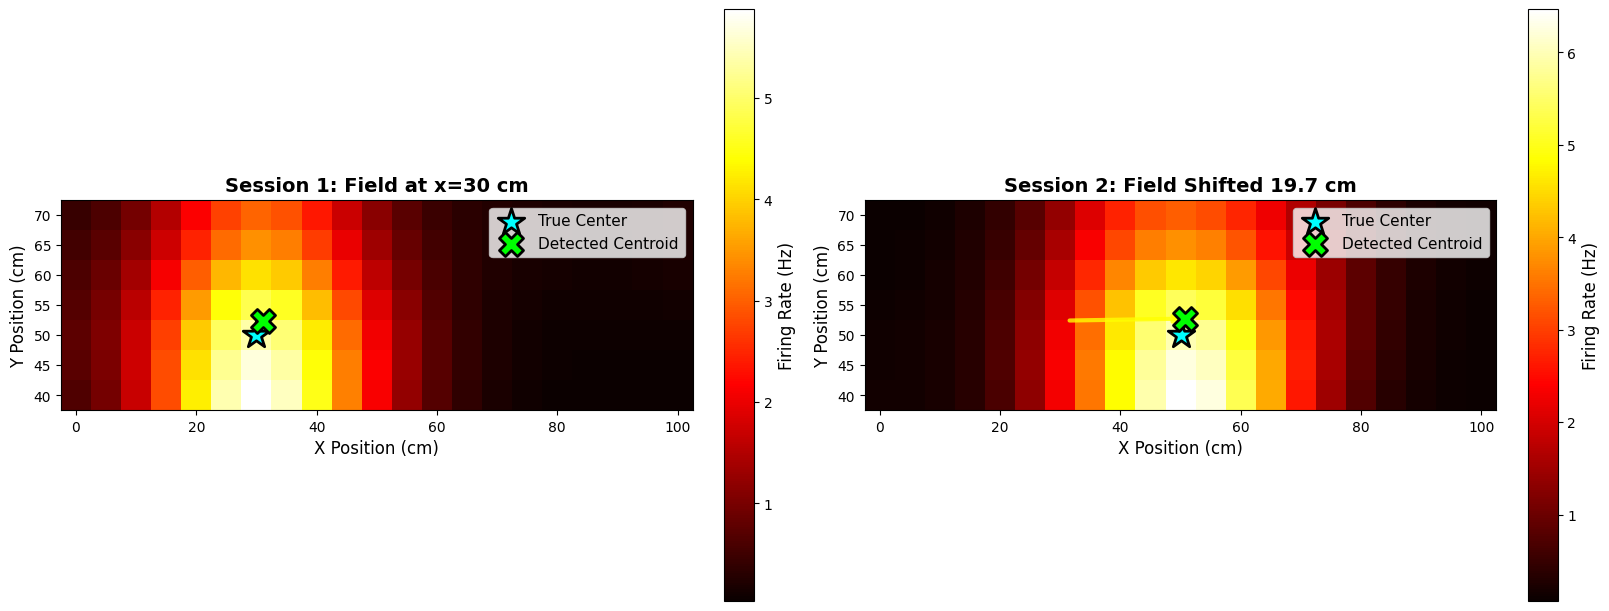

In [19]:
# Visualize the shift
fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

# Session 1 - let colormap autoscale to avoid black appearance of low firing rates
track_env.plot_field(
    rate_session1,
    ax=axes[0],
    cmap="hot",
    colorbar_label="Firing Rate (Hz)",
)
axes[0].scatter(
    field_center_session1[0],
    field_center_session1[1],
    s=400,
    c="cyan",
    marker="*",
    edgecolors="black",
    linewidths=2,
    label="True Center",
    zorder=10,
)
if len(fields_session1) > 0:
    axes[0].scatter(
        centroid_s1[0],
        centroid_s1[1],
        s=300,
        c="lime",
        marker="X",
        edgecolors="black",
        linewidths=2,
        label="Detected Centroid",
        zorder=10,
    )
axes[0].set_title("Session 1: Field at x=30 cm", fontsize=14, fontweight="bold")
axes[0].legend(fontsize=11)

# Session 2
track_env.plot_field(
    rate_session2,
    ax=axes[1],
    cmap="hot",
    colorbar_label="Firing Rate (Hz)",
)
axes[1].scatter(
    field_center_session2[0],
    field_center_session2[1],
    s=400,
    c="cyan",
    marker="*",
    edgecolors="black",
    linewidths=2,
    label="True Center",
    zorder=10,
)
if len(fields_session2) > 0:
    axes[1].scatter(
        centroid_s2[0],
        centroid_s2[1],
        s=300,
        c="lime",
        marker="X",
        edgecolors="black",
        linewidths=2,
        label="Detected Centroid",
        zorder=10,
    )
    # Draw arrow showing shift
    axes[1].annotate(
        "",
        xy=(centroid_s2[0], centroid_s2[1]),
        xytext=(centroid_s1[0], centroid_s1[1]),
        arrowprops={
            "arrowstyle": "->",
            "lw": 3,
            "color": "yellow",
            "alpha": 0.8,
        },
    )
axes[1].set_title(
    f"Session 2: Field Shifted {shift_distance:.1f} cm", fontsize=14, fontweight="bold"
)
axes[1].legend(fontsize=11)

plt.show()

### Example 2: 2D T-Maze with Geodesic Distance

Now let's demonstrate why **geodesic distance** is important for complex environments. In a T-maze, a place field shifting from one arm to another might have a short Euclidean distance (straight through the wall) but a much longer geodesic distance (following the path through the maze).

This example uses the **2D Shapely polygon-based T-maze** created earlier, showing how geodesic distance correctly accounts for the maze structure.

In [20]:
# Use the trajectory from the 2D Shapely-based T-maze created earlier
# This provides good coverage of all maze arms
maze_positions = tmaze_positions
maze_times = tmaze_times

print(
    f"Using 2D T-maze trajectory: {len(maze_positions)} points over {maze_times[-1]:.1f}s"
)
print(f"T-maze is 2D polygon with {tmaze_env.n_bins} bins")

# Session A: Place field at stem start (bottom of stem)
# Using coordinates from the Shapely-based T-maze
stem_start_center = np.array([0.0, stem_length / 4])  # Bottom quarter of stem
pc_stem = PlaceCellModel(
    tmaze_env,
    center=stem_start_center,
    width=10.0,
    max_rate=18.0,
    baseline_rate=0.1,
    distance_metric="euclidean",
    seed=200,
)

spikes_stem = generate_poisson_spikes(
    firing_rate=pc_stem.firing_rate(maze_positions, maze_times),
    times=maze_times,
    refractory_period=0.002,
    seed=200,
)

rate_stem = compute_place_field(
    tmaze_env,
    spikes_stem,
    maze_times,
    maze_positions,
    bandwidth=8.0,  # Match 08_spike_field_basics.py for consistent smoothing
)

# Session B: Place field at left arm end (far from stem start)
# Left arm center: midpoint along the left arm
left_arm_end_center = np.array(
    [-(arm_length * 0.75), stem_length + corridor_width / 2]
)  # 3/4 along left arm
pc_arm = PlaceCellModel(
    tmaze_env,
    center=left_arm_end_center,
    width=10.0,
    max_rate=18.0,
    baseline_rate=0.1,
    distance_metric="euclidean",
    seed=201,
)

spikes_arm = generate_poisson_spikes(
    firing_rate=pc_arm.firing_rate(maze_positions, maze_times),
    times=maze_times,
    refractory_period=0.002,
    seed=201,
)

rate_arm = compute_place_field(
    tmaze_env,
    spikes_arm,
    maze_times,
    maze_positions,
    bandwidth=8.0,  # Match 08_spike_field_basics.py for consistent smoothing
)

print(f"\nSession A (stem start): {len(spikes_stem)} spikes")
print(f"Session B (arm end): {len(spikes_arm)} spikes")

Using 2D T-maze trajectory: 20000 points over 400.0s
T-maze is 2D polygon with 84 bins

Session A (stem start): 639 spikes
Session B (arm end): 1837 spikes


In [21]:
# Detect fields
fields_stem = detect_place_fields(
    rate_stem,
    tmaze_env,
    threshold=0.2,
    detect_subfields=False,
)

fields_arm = detect_place_fields(
    rate_arm,
    tmaze_env,
    threshold=0.2,
    detect_subfields=False,
)

print("\nDetected fields:")
print(f"  Stem start: {len(fields_stem)} field(s)")
print(f"  Arm end: {len(fields_arm)} field(s)")


Detected fields:
  Stem start: 1 field(s)
  Arm end: 1 field(s)


In [22]:
# Measure shift with BOTH Euclidean and geodesic distance
if len(fields_stem) > 0 and len(fields_arm) > 0:
    # Euclidean distance (straight line)
    shift_euclidean = field_shift_distance(
        rate_stem,
        fields_stem[0],
        tmaze_env,
        rate_arm,
        fields_arm[0],
        tmaze_env,
        use_geodesic=False,
    )

    # Geodesic distance (following the maze path)
    shift_geodesic = field_shift_distance(
        rate_stem,
        fields_stem[0],
        tmaze_env,
        rate_arm,
        fields_arm[0],
        tmaze_env,
        use_geodesic=True,
    )

    # Compute ground truth distances
    euclidean_truth = np.linalg.norm(left_arm_end_center - stem_start_center)

    print("\n" + "=" * 60)
    print("PLACE FIELD SHIFT: T-MAZE (Euclidean vs Geodesic)")
    print("=" * 60)
    print(f"Euclidean distance:  {shift_euclidean:.1f} cm (straight line)")
    print(f"Geodesic distance:   {shift_geodesic:.1f} cm (following maze path)")
    print(f"\nRatio (geodesic/euclidean): {shift_geodesic / shift_euclidean:.2f}x")
    print("\nInterpretation:")
    print("  The field 'shifted' from stem start to arm end.")
    print(f"  Euclidean distance: {shift_euclidean:.1f} cm (straight line)")
    print(f"  Geodesic distance: {shift_geodesic:.1f} cm (actual path through maze)")
    print(f"  Geodesic is {shift_geodesic - shift_euclidean:.1f} cm longer!")
    print("\n  For mazes and complex environments, always use geodesic distance!")


PLACE FIELD SHIFT: T-MAZE (Euclidean vs Geodesic)
Euclidean distance:  62.2 cm (straight line)
Geodesic distance:   74.1 cm (following maze path)

Ratio (geodesic/euclidean): 1.19x

Interpretation:
  The field 'shifted' from stem start to arm end.
  Euclidean distance: 62.2 cm (straight line)
  Geodesic distance: 74.1 cm (actual path through maze)
  Geodesic is 12.0 cm longer!

  For mazes and complex environments, always use geodesic distance!


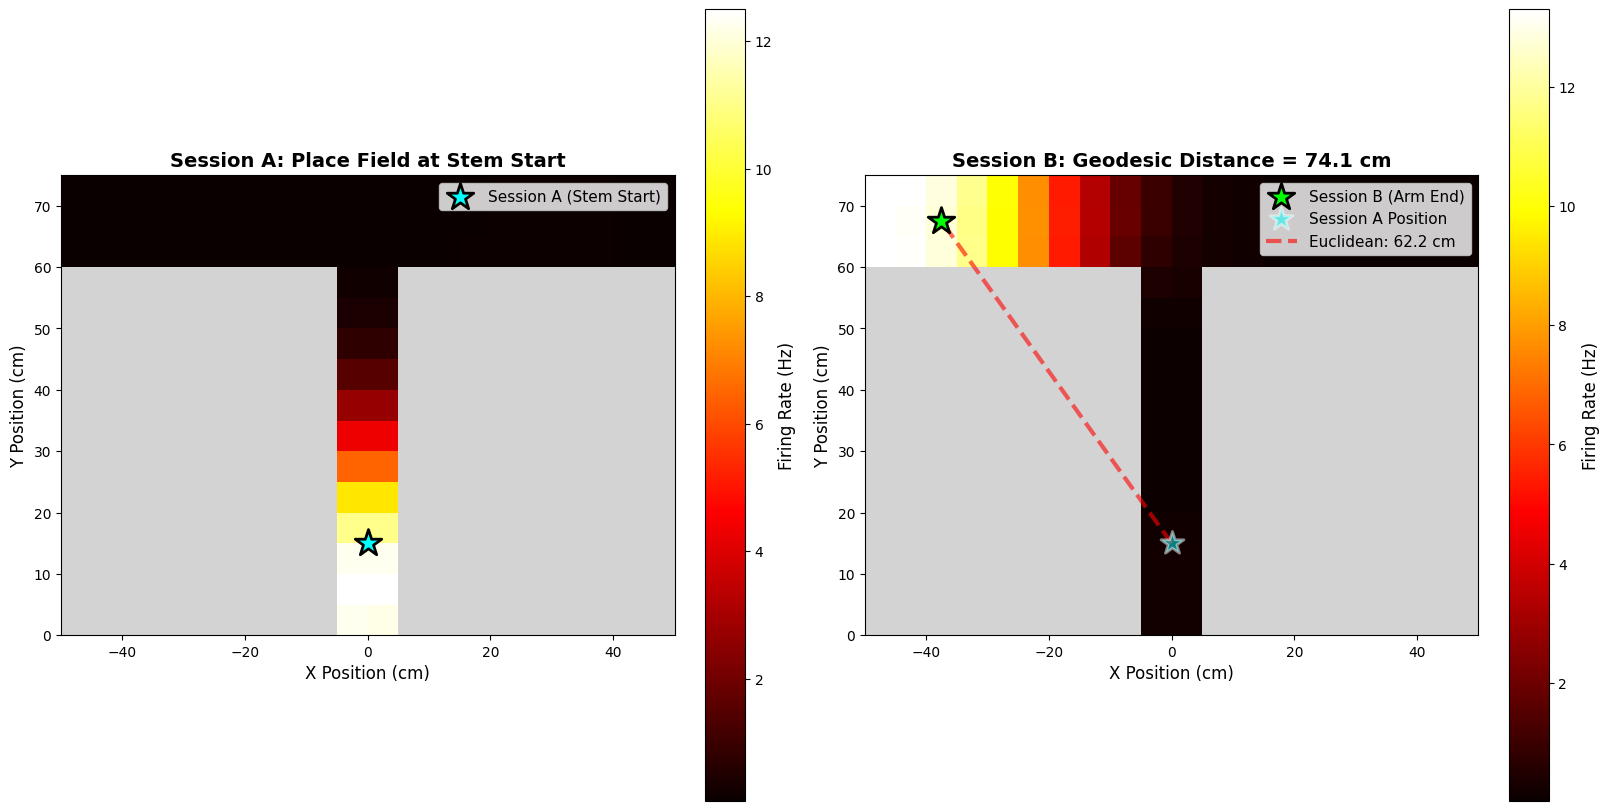


KEY INSIGHT
For T-mazes, plus-mazes, or any environment with barriers:
  - Euclidean distance measures straight-line distance (ignores walls)
  - Geodesic distance measures actual path distance (respects maze structure)

Always use geodesic distance for complex environments!


In [23]:
# Visualize both measurements
fig, axes = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)

# Stem field (Session A)
tmaze_env.plot_field(
    rate_stem,
    ax=axes[0],
    cmap="hot",
    colorbar_label="Firing Rate (Hz)",
)
axes[0].scatter(
    stem_start_center[0],
    stem_start_center[1],
    s=400,
    c="cyan",
    marker="*",
    edgecolors="black",
    linewidths=2,
    label="Session A (Stem Start)",
    zorder=10,
)
axes[0].set_title(
    "Session A: Place Field at Stem Start", fontsize=14, fontweight="bold"
)
axes[0].legend(fontsize=11)

# Arm field (Session B) with both distance visualizations
tmaze_env.plot_field(
    rate_arm,
    ax=axes[1],
    cmap="hot",
    colorbar_label="Firing Rate (Hz)",
)
axes[1].scatter(
    left_arm_end_center[0],
    left_arm_end_center[1],
    s=400,
    c="lime",
    marker="*",
    edgecolors="black",
    linewidths=2,
    label="Session B (Arm End)",
    zorder=10,
)
axes[1].scatter(
    stem_start_center[0],
    stem_start_center[1],
    s=300,
    c="cyan",
    marker="*",
    edgecolors="white",
    linewidths=2,
    label="Session A Position",
    alpha=0.5,
    zorder=9,
)

# Draw Euclidean distance (dashed line)
axes[1].plot(
    [stem_start_center[0], left_arm_end_center[0]],
    [stem_start_center[1], left_arm_end_center[1]],
    "r--",
    linewidth=3,
    alpha=0.6,
    label=f"Euclidean: {shift_euclidean:.1f} cm",
)

axes[1].set_title(
    f"Session B: Geodesic Distance = {shift_geodesic:.1f} cm",
    fontsize=14,
    fontweight="bold",
)
axes[1].legend(fontsize=11)

plt.show()

print("\n" + "=" * 60)
print("KEY INSIGHT")
print("=" * 60)
print("For T-mazes, plus-mazes, or any environment with barriers:")
print("  - Euclidean distance measures straight-line distance (ignores walls)")
print("  - Geodesic distance measures actual path distance (respects maze structure)")
print("\nAlways use geodesic distance for complex environments!")

### When to Use Euclidean vs Geodesic Distance

**Use Euclidean distance** (`use_geodesic=False`) when:
- Open field environments with no barriers
- Computational speed is critical
- You want to compare to older literature (most papers use Euclidean)

**Use Geodesic distance** (`use_geodesic=True`) when:
- Mazes (T-maze, plus-maze, radial arm maze)
- Multi-room environments
- Environments with barriers or walls
- You need accurate path-based distance measurements

**Key Functions**:
- `field_shift_distance()` - Measures centroid displacement between sessions
- `field_centroid()` - Computes rate-weighted center of mass
- `detect_place_fields()` - Finds place field bins

## Summary

In this notebook, we demonstrated:

1. **Firing Rate Computation**: Converting spike trains to spatial maps with occupancy normalization
2. **Place Field Detection**: Automatic identification using peak-based segmentation
3. **Field Properties**: Computing size and centroid for each field
4. **Spatial Metrics**: Skaggs information and sparsity for quantifying spatial coding
5. **Stability Analysis**: Split-half correlation to assess field reliability
6. **Complete Workflow**: End-to-end analysis function
7. **T-Maze Analysis**: Working with irregular environments
8. **Place Remapping**: Quantifying how place fields change between environments
9. **Place Field Shift Measurement**: Measuring centroid displacement with Euclidean and geodesic distances

### Key Functions Used

- `compute_place_field()` - Spike train → firing rate map
- `detect_place_fields()` - Automatic field detection
- `field_size()` - Field area in physical units
- `field_centroid()` - Center of mass
- `skaggs_information()` - Spatial information (bits/spike)
- `sparsity()` - Firing sparsity [0, 1]
- `field_stability()` - Temporal stability (correlation)
- `field_shift_distance()` - Measure distance between field centroids (Euclidean or geodesic)

### References

- O'Keefe & Dostrovsky (1971): Discovery of place cells
- Skaggs et al. (1993): Spatial information metric
- Skaggs et al. (1996): Sparsity metric
- Muller & Kubie (1987, 1989): Place field characterization
- Wilson & McNaughton (1993): Population dynamics

### Next Steps

- Try with real experimental data
- Analyze populations of place cells (see population metrics)
- Compare place fields across conditions
- Analyze boundary cells (see boundary cell notebook)